# Vizualizações dos dados de acidentes de trânsito no Brasil

Dados extraídos do site da ANTT (Agência Nacional de Transportes Terrestres) e disponibilizados no site [Dados Abertos](https://dados.antt.gov.br/group/rodovias) do governo brasileiro.

Serão apenas considerados os dados dos últimos 5 anos, de 2019 a 2024.

In [1]:
import pandas as pd
import geopandas as geopandas
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import os

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Abrindo os dados

Os dados estão separados por concessíonárias.

In [3]:
dfs = {}
path = './data/acidentes'

for file in os.listdir(path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
        concessionaria = file.split('_')[2][:-4]
        dfs[concessionaria] = df

dfs

/tmp/ipykernel_1449581/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1449581/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1449581/816295864.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1449581/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1449581/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.rea

{'msvia':              data   horario  n_da_ocorrencia tipo_de_ocorrencia       km  \
 0      11/10/2014  12:21:00                6         sem vítima     92.1   
 1      11/10/2014  08:17:00              139         sem vítima      468   
 2      11/10/2014  08:34:00              149         com vítima      483   
 3      11/10/2014  06:36:00              287         sem vítima    289.1   
 4      11/10/2014  07:31:00              297         com vítima      295   
 ...           ...       ...              ...                ...      ...   
 15220  15/06/2024  09:45:29               13         Com vítima   90,624   
 15221  15/06/2024  10:17:01               20         Com vítima  427,000   
 15222  16/06/2024  03:29:00               67         Com vítima  461,254   
 15223  16/06/2024  05:38:39               96         Com vítima  511,790   
 15224  16/06/2024  12:25:31              154         Com vítima  270,508   
 
           trecho      sentido                  tipo_de_acidente 

## Filtrando os dados apenas de 2019 a 2024

In [4]:
# datas para datetime
new_dfs = []
for key, df in dfs.items():
    df['concessionaria'] = key
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
    df['data_hora'] = pd.to_datetime(df['data'].astype(str) + ' ' + df['horario'], format='%Y-%m-%d %H:%M:%S')
    df['com_vitima'] = True if df['tipo_de_ocorrencia'].str.contains('com').any() else False
    df.drop(columns=['tipo_de_ocorrencia','data','horario'], inplace=True)
    df = df[df['data_hora'].dt.year >= 2019]
    new_dfs.append(df)

new_dfs[0]

,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,trator_maquinas,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima
6594,4,721.589,BR-163/MS,Norte,Atropelamento de animais,1,0,0,0,0,...,0,0,1,0,0,0,0,msvia,2019-01-01 12:32:00,True
6595,20,654.382,BR-163/MS,Sul,Tombamento de moto,0,0,0,1,0,...,0,0,0,0,1,0,0,msvia,2019-01-01 04:53:00,True
6596,21,288,BR-163/MS,Norte,Colisão com veículos (frontal),1,0,0,1,0,...,0,0,2,2,0,0,1,msvia,2019-01-01 05:00:00,True
6597,66,462.272,BR-163/MS,Sul,Tombamento de moto,0,0,0,1,0,...,0,0,0,2,0,0,0,msvia,2019-01-01 09:12:00,True
6598,113,552,BR-163/MS,Norte,Saídas de pista,1,0,0,0,0,...,0,0,3,0,0,0,0,msvia,2019-01-01 12:35:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15220,13,"90,624",BR-163/MS,Decrescente,Queda de moto,0,0,0,1,0,...,0,0,0,0,0,0,0,msvia,2024-06-15 09:45:29,True
15221,20,"427,000",BR-163/MS,Crescente,Acidentes de outra natureza,1,0,0,0,0,...,0,0,0,0,0,0,0,msvia,2024-06-15 10:17:01,True
15222,67,"461,254",BR-163/MS,Decrescente,Acidentes de outra natureza,0,0,0,0,0,...,0,0,0,0,0,0,0,msvia,2024-06-16 03:29:00,True
15223,96,"511,790",BR-163/MS,Crescente,Acidentes de outra natureza,0,0,1,0,0,...,0,0,0,0,0,0,0,msvia,2024-06-16 05:38:39,True


## Concatenando os datasets

In [5]:
df_final = pd.concat(new_dfs, ignore_index=True)

print(df_final.info())
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347828 entries, 0 to 347827
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   n_da_ocorrencia                 347828 non-null  object        
 1   km                              347828 non-null  object        
 2   trecho                          347828 non-null  object        
 3   sentido                         347824 non-null  object        
 4   tipo_de_acidente                347388 non-null  object        
 5   automovel                       347828 non-null  int64         
 6   bicicleta                       347828 non-null  int64         
 7   caminhao                        347828 non-null  int64         
 8   moto                            347828 non-null  int64         
 9   onibus                          347828 non-null  int64         
 10  outros                          347828 non-null  int64  

,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,trator_maquinas,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima
0,4,721.589,BR-163/MS,Norte,Atropelamento de animais,1,0,0,0,0,...,0,0,1,0,0,0,0,msvia,2019-01-01 12:32:00,True
1,20,654.382,BR-163/MS,Sul,Tombamento de moto,0,0,0,1,0,...,0,0,0,0,1,0,0,msvia,2019-01-01 04:53:00,True
2,21,288,BR-163/MS,Norte,Colisão com veículos (frontal),1,0,0,1,0,...,0,0,2,2,0,0,1,msvia,2019-01-01 05:00:00,True
3,66,462.272,BR-163/MS,Sul,Tombamento de moto,0,0,0,1,0,...,0,0,0,2,0,0,0,msvia,2019-01-01 09:12:00,True
4,113,552,BR-163/MS,Norte,Saídas de pista,1,0,0,0,0,...,0,0,3,0,0,0,0,msvia,2019-01-01 12:35:00,True


In [6]:
import re
def limpar_string(valor):
    if isinstance(valor, str): # apenas limpa oq não é possivel identificar como float, ou seja, contém algum erro
        valor_limpo = re.sub(r'[^\d.]', '', valor) 
        return valor_limpo
    return valor

# funcação necessária pq tinham valores com vírgula, ponto e erros grotescos como:
# "263+289" | "a675,812"

In [7]:
df_final['km'] = df_final['km'].apply(limpar_string)
df_final['km'] = df_final['km'].astype(float)
print("Tipo de dado da coluna 'km':",df_final['km'].dtype)
df_final.head()

Tipo de dado da coluna 'km': float64


,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,trator_maquinas,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima
0,4,721.589,BR-163/MS,Norte,Atropelamento de animais,1,0,0,0,0,...,0,0,1,0,0,0,0,msvia,2019-01-01 12:32:00,True
1,20,654.382,BR-163/MS,Sul,Tombamento de moto,0,0,0,1,0,...,0,0,0,0,1,0,0,msvia,2019-01-01 04:53:00,True
2,21,288.000,BR-163/MS,Norte,Colisão com veículos (frontal),1,0,0,1,0,...,0,0,2,2,0,0,1,msvia,2019-01-01 05:00:00,True
3,66,462.272,BR-163/MS,Sul,Tombamento de moto,0,0,0,1,0,...,0,0,0,2,0,0,0,msvia,2019-01-01 09:12:00,True
4,113,552.000,BR-163/MS,Norte,Saídas de pista,1,0,0,0,0,...,0,0,3,0,0,0,0,msvia,2019-01-01 12:35:00,True


In [8]:
print("O DataFrame Final possui {} linhas e {} colunas".format(df_final.shape[0], df_final.shape[1]))

O DataFrame Final possui 347828 linhas e 23 colunas


## Plots

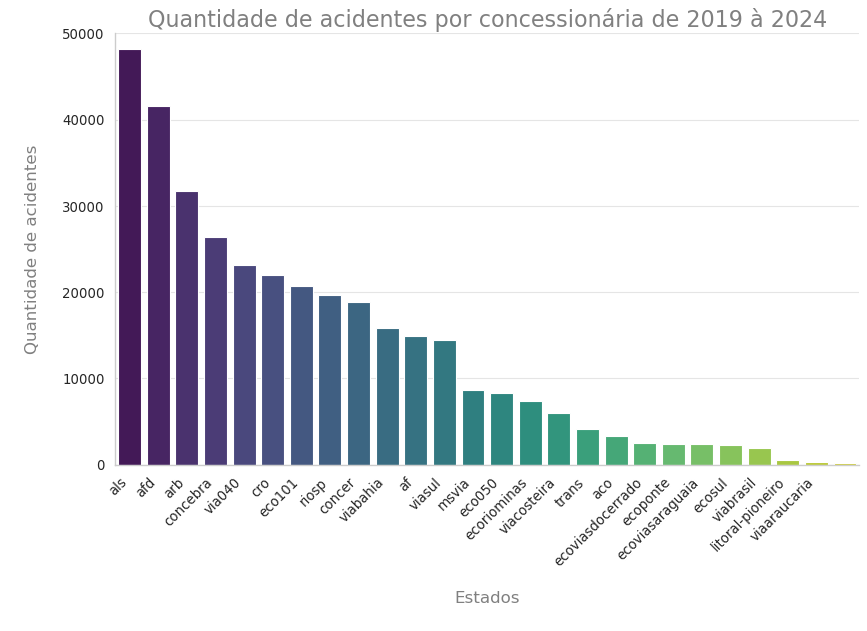

In [72]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=df_final['concessionaria'].value_counts().index, 
                 y=df_final['concessionaria'].value_counts().values, 
                 palette='viridis')
plt.title('Quantidade de acidentes por concessionária de 2019 à 2024', fontsize=20, color='gray')

# total = df_final.shape[0]
# for i in ax.patches:
#     ax.text(i.get_x()+0.03, i.get_height() - 1500, 
#             str(round((i.get_height()/total)*100, 2))+"%", 
#             ha='center', 
#             fontsize=12,
#             weight='bold',
#             color='white')

plt.xlabel('\nEstados\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, 50000)

plt.grid(axis='y', alpha=0.5)

# for i in ['bottom', 'left']:
#     ax.spines[i].set_color('white')
#     ax.spines[i].set_linewidth(1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.show()

In [10]:
df_final['estado'] = df_final['trecho'].str.split('/').str[1]
df_final.head(1)

,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima,estado
0,4,721.589,BR-163/MS,Norte,Atropelamento de animais,1,0,0,0,0,...,0,1,0,0,0,0,msvia,2019-01-01 12:32:00,True,MS


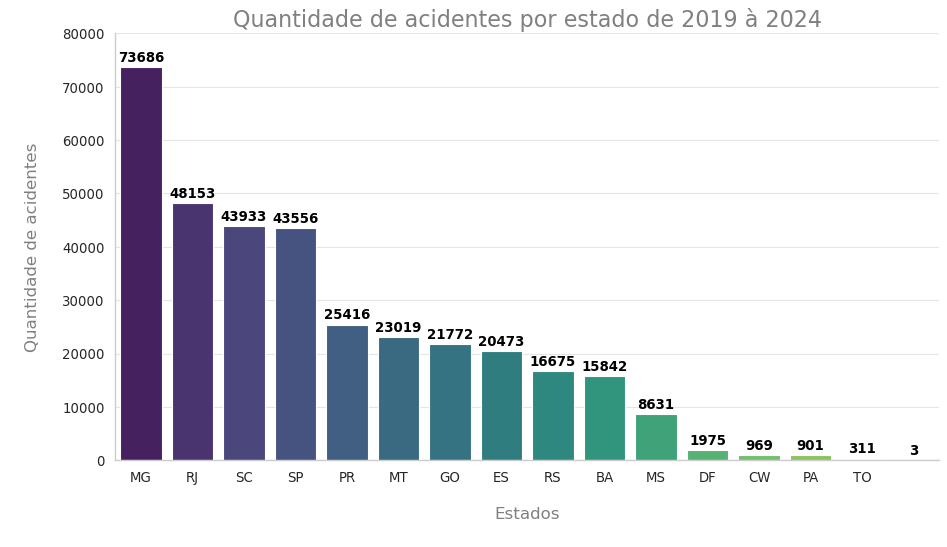

In [79]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=df_final['estado'].value_counts().index, y=df_final['estado'].value_counts().values, palette='viridis')
plt.title('Quantidade de acidentes por estado de 2019 à 2024', fontsize=20, color='gray')


for i in ax.patches:
    ax.text(i.get_x()+0.4, i.get_height() + 1000, 
            str(int(i.get_height())), 
            ha='center', 
            fontsize=12,
            weight='bold',
            color='black')

plt.xlabel('\nEstados\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, 80000)

plt.grid(axis='y', alpha=0.5)

# for i in ['bottom', 'left']:
#     ax.spines[i].set_color('white')
#     ax.spines[i].set_linewidth(1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.tight_layout()

plt.show()

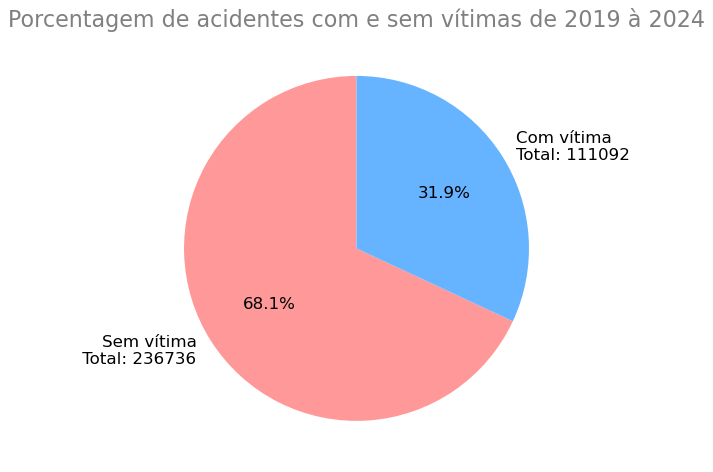

In [30]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

total_sem_vitimas = df_final['com_vitima'].sum()
total_vitimas = df_final.shape[0] - total_sem_vitimas

ax = plt.pie(df_final['com_vitima'].value_counts(), 
             labels=[f'Sem vítima\n Total: {total_sem_vitimas}', f'Com vítima\nTotal: {total_vitimas}'], 
             autopct='%1.1f%%', 
             startangle=90, 
             colors=['#ff9999','#66b3ff'], 
             textprops={'fontsize': 15})

plt.title('Porcentagem de acidentes com e sem vítimas de 2019 à 2024', fontsize=20, color='gray')

plt.show()

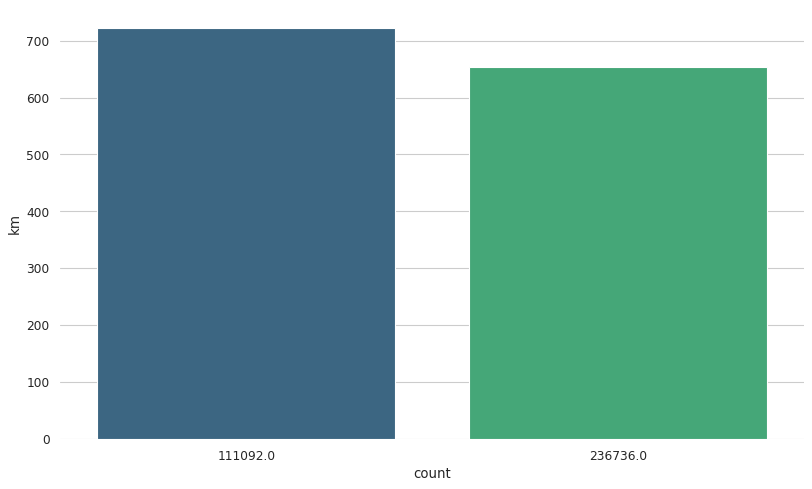

In [86]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

ax = sns.barplot(x=df_final['com_vitima'].value_counts(), 
                 y=df_final['km'], 
                 palette='viridis')
sns.despine(left=True, bottom=True)
plt.show()

## Cruzando com as pistas para pegar as posições geográficas

*Feito em outro notebook, apenas copiando o código*

In [13]:
pista_principal_df = pd.read_csv('data/km_pista_principal/dados_dos_quilometro_principal.csv', sep=';', encoding='latin1')
pista_principal_df['latitude'] = pista_principal_df['latitude'].str.replace(',', '.').astype(float)
pista_principal_df['longitude'] = pista_principal_df['longitude'].str.replace(',', '.').astype(float)
pista_principal_df['km_m'] = pista_principal_df['km_m'].str.replace(',', '.').astype(float)

In [14]:

for i, row in pista_principal_df.iterrows():
    concessionaria = row['concessionaria']
    km = row['km_m']
    lat = row['latitude']
    long = row['longitude']
    df_final_concessionaria = df_final[df_final['concessionaria'] == concessionaria]
    df_final_km = df_final_concessionaria[df_final_concessionaria['km'] == km]
    geo = (df_final_km['latitude'].values, df_final_km['longitude'].values)

    print(concessionaria, km, geo)

KeyError: 'latitude'